# Constructing Property Diagrams

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# VDW Equation of State

### Equation of state:
$$P = \dfrac{RT}{\underline{V} - b} - \dfrac{a}{\underline{V}^2}$$ 

where 

$$ a = 27\dfrac{(RT_c)^2}{64P_c} \text{and } b = 0.125\dfrac{RT_c}{P_c}$$ 

### Expression it in its cubic form:

$$ Z^3 + \alpha Z^2 + \beta Z + \gamma = 0 $$

where 

$\quad \alpha = -1 - B$

$\quad \beta = A$

$\quad \gamma = -AB$

where the constants $A$ and $B$ are given as: 

$ A = \dfrac{aP}{RT}^2 $
$ B = \dfrac{bP}{RT}$


### Fugacity expression from Sandler (Eq 7.4-13):

Sandler gives the fugacity coefficient, $\phi$ for the VDW equation of state as:

$$\ln{\phi} = (Z-1) - \ln{(Z-B)} - \dfrac{A}{Z}$$

## Critical Properties of Ethane

In [2]:
MW = 30.070 #g/mol
Tc = 305.4#K
Pc = 4.884*10**6#Pa
Vc = 0.148/1000#(m^3/mol)
w = 0.098
R = 8.314#J/(mol*K)
Zc = Pc*Vc/(R*Tc)
print('%3.3f'%Zc)

0.285


In [3]:
a = 27*(R*Tc)**2/(64*Pc)
b = 0.125*(R*Tc)/Pc

print('%3.2f'%a,'%3.2f'%(b*1000))

0.56 0.06


Text(0.5, 0, '$V (m^3/mol)$')

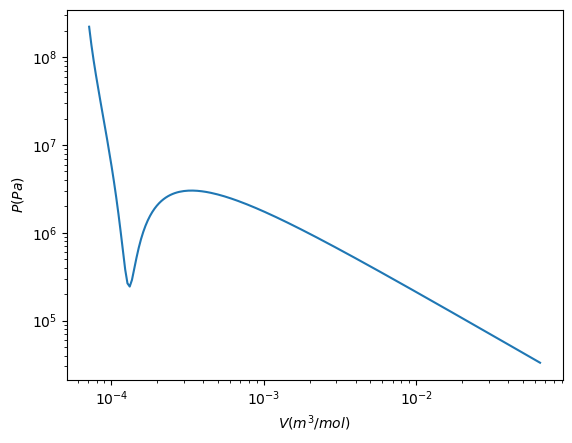

In [12]:
def VDW(V,T):
    '''
    V in m^3/mol
    T in K
    
    returns P in Pa
    '''
    return R*T/(V-b)-a/V**2

V = np.logspace(np.log10(1.1*b), np.log10(1000*b),201)
T = 0.85*Tc
plt.plot(V,VDW(V, T))
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$P (Pa)$')
plt.xlabel(r'$V (m^3/mol)$')

### Calculating the Fugacity from the Cubic Form of the E.O.S

In [13]:
def VDW_cubic(T,P):
    '''
    takes in temperature in K
    takes in pressure in Pa
    
    returns roots of the E.oS. in compressibility, Z, and the fugacities of the v and l phases
    '''
    def fugacity(Z):
    
        return  (Z-1) - np.log(Z-B) - A/Z
    
    A = a*P/(R*T)**2
    B = b*P/(R*T)

    roots_ = np.roots([1, -1 - B, A, -A*B]) ##calculate the compressibility roots

    Zv = np.max(roots_)
    Zl = np.min(roots_)

    fv_ = fugacity(Zv)
    fl_ = fugacity(Zl)
    
    return roots_, [fv_,fl_]

### Computing the Fugacities as a Function of the Guess Pressures

C:\Users\richa\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


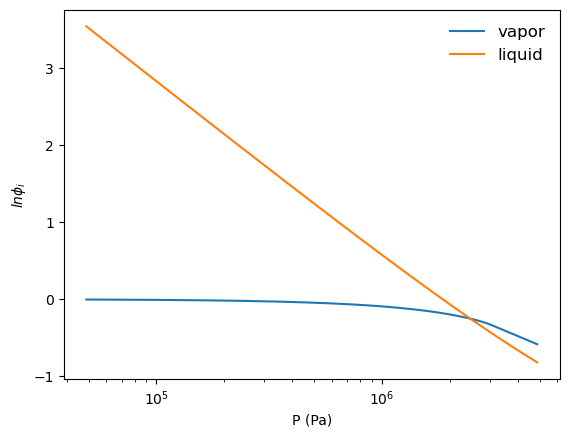

In [18]:
P_ = np.logspace(-2,0,1001)*Pc

roots_ = []
fv_ = []
fl_ = []
for P in P_:

    roots,f = VDW_cubic(T,P)
    roots_.append(roots)
    fv_.append(f[0])
    fl_.append(f[1])
    

fv_ = np.asarray(fv_)
fl_ = np.asarray(fl_)

plt.plot(P_,fv_, label = 'vapor')
plt.plot(P_,fl_, label = 'liquid')
plt.xscale('log')
plt.xlabel('P (Pa)')
plt.ylabel('$ln\phi_i$')
plt.legend(fontsize=12,frameon=False)

## Finding the intersection of the two fugacities gives the vapor pressure

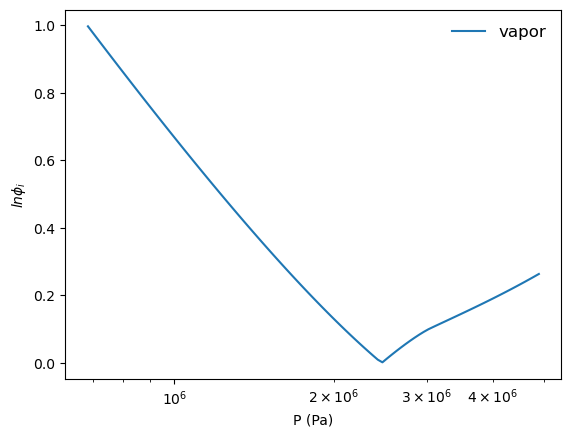

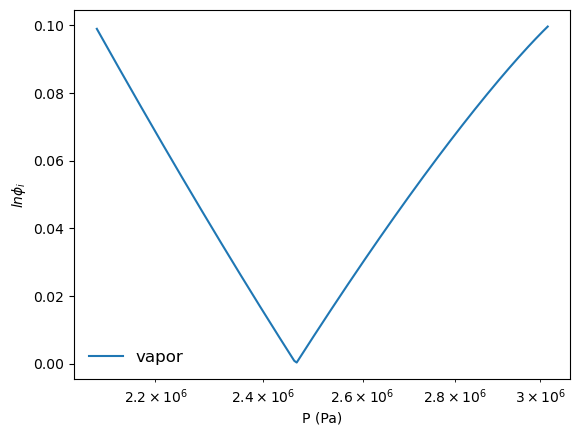

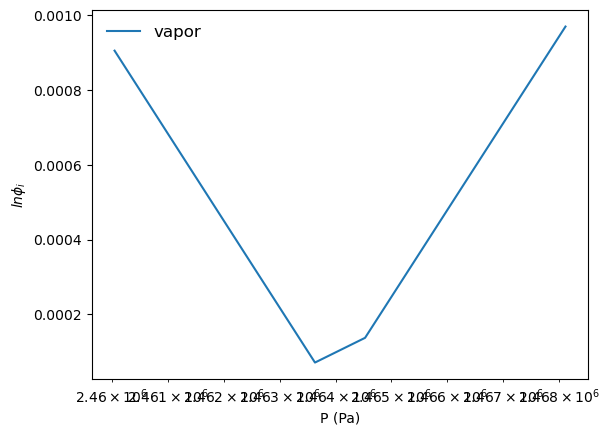

259.59 2463631.3069065055 0.0006098789812897459 0.00010788152979104126


In [59]:
def find_Psat(Pmin,Pmax, thresh = 1):
    ##first guess is broad search
    P_ = np.logspace(np.log10(Pmin),np.log10(Pmax),1000)
    roots_ = []
    fv_ = []
    fl_ = []
    for P in P_:

        roots,f = VDW_cubic(T,P)
        roots_.append(roots)
        fv_.append(f[0])
        fl_.append(f[1])


    fv_ = np.asarray(fv_)
    fl_ = np.asarray(fl_)

    diff = np.abs(fl_-fv_)
    mask = (diff < thresh)
    
    return P_[mask], diff[mask]

P1,diff1 = find_Psat(0.01,Pc)

plt.plot(P1,diff1, label = 'vapor')
plt.xscale('log')
plt.xlabel('P (Pa)')
plt.ylabel('$ln\phi_i$')
plt.legend(fontsize=12,frameon=False)
plt.show()

#second guess is a tighter search
P2,diff2 = find_Psat(np.min(P1),np.max(P1),thresh=0.1)

plt.plot(P2,diff2, label = 'vapor')
plt.xscale('log')
plt.xlabel('P (Pa)')
plt.ylabel('$ln\phi_i$')
plt.legend(fontsize=12,frameon=False)
plt.show()

#third guess is a tighter search
P3,diff3 = find_Psat(np.min(P2),np.max(P2),thresh=0.001)

plt.plot(P3,diff3, label = 'vapor')
plt.xscale('log')
plt.xlabel('P (Pa)')
plt.ylabel('$ln\phi_i$')
plt.legend(fontsize=12,frameon=False)
plt.show()


Psat = P3[list(diff3).index(np.min(diff3))]
roots,f = VDW_cubic(T,Psat)
Vv = np.max(roots)*R*T/(Psat)
Vl = np.min(roots)*R*T/(Psat)
print(T, Psat, Vv, Vl)


## Plotting the Real Isotherm

Text(0.5, 0, '$V$ $(m^3/mol)$')

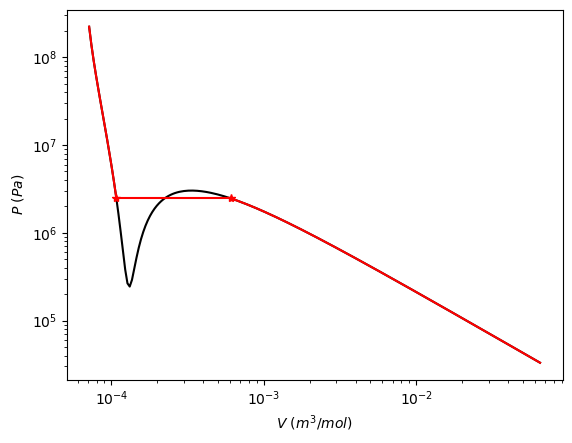

In [64]:
isotherm = VDW(V, T)
mask = V < Vl
plt.plot(V[mask], isotherm[mask], c='r')
mask = V > Vv
plt.plot(V[mask], isotherm[mask], c='r')
plt.plot([Vl,Vv], [Psat,Psat], c='r', label = T)
plt.plot(V,isotherm,'-k',zorder=0)
plt.plot([Vl],Psat,'r*')
plt.plot([Vv],Psat,'r*')

plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$P$ $(Pa)$')
plt.xlabel(r'$V$ $(m^3/mol)$')

In [62]:
def iterate2findPsat(T, Pmin=0.01*Pc,Pmax=Pc, thresh = 1):
    
    P_ = np.logspace(np.log10(Pmin),np.log10(Pmax),1000)
    for i in np.arange(5):
        
        roots_ = []
        fv_ = []
        fl_ = []
        for P in P_:

            roots,f = VDW_cubic(T,P)
            roots_.append(roots)
            fv_.append(f[0])
            fl_.append(f[1])


        fv_ = np.asarray(fv_)
        fl_ = np.asarray(fl_)

        diff = np.abs(fl_-fv_)
        mask = (diff < thresh/2**i)
        P_ = np.logspace(np.log10(np.min(P_[mask])),np.log10(np.max(P_[mask])),1000)
    
    Psat = P_[mask][list(diff[mask]).index(np.min(diff[mask]))]
    
    return Psat

for Tr in np.arange(0.5,0.99,0.01):
    test = iterate2findPsat(Tr*Tc)
    print(test)

135695.78472385704
154991.77464208688
176170.00734593684
199306.4858694622
224502.93700012527
251843.12434774838
281477.17838234577
313412.9636601845
347779.1506714817
384656.2389742191
424069.7195766826
466205.5450829386
511126.6023970411
558826.5870055164
609494.1402338201
663075.9384054104
719747.2805749156
779249.9096748888
842541.0935943672
908559.7427117148
977992.9967206203
1050925.0308836836
1127347.0899431615
1207066.243238512
1290272.5817792227
1377175.865596366
1467467.578922822
1561828.2064113556
1659235.0305047852
1760351.9454615272
1866115.9271268677
1974106.493174444
2086069.004158627
2200525.731682629
2315592.0873162835
2434330.1075021923
2558484.6778680277
2687136.393723781
2822833.0008527143
2970348.7522905516
3125263.232702889
3287919.500211769
3497943.2894588965
3727176.3525457904
3977696.6734803286
4178127.473124395
4329654.433987064
4478727.935914555
4622090.478330923
